In [17]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import scipy.optimize as opt
import scipy.spatial

In [18]:
def gaussian_kernel(X, Xprime, eta):
    """
    Compute the Gaussian kernel matrix between two sets of data points.

    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        The first set of data points.
    Xprime : array, shape (m_samples, n_features)
        The second set of data points.
    eta : array, shape (1,)
        The kernel hyperparameter.

    Returns
    -------
    K : array, shape (n_samples, m_samples)
        The kernel matrix between the two sets of data points.
    """
    gamma = eta[0]
    dists = scipy.spatial.distance.cdist(X, Xprime, metric="sqeuclidean")
    return np.exp(-gamma * dists)

In [19]:
def special_kernel(X, Xprime, eta):
    """
    Compute the special kernel matrix between two sets of data points.

    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        The first set of data points.
    Xprime : array, shape (m_samples, n_features)
        The second set of data points.
    eta : array, shape (2,)
        The kernel hyperparameters.

    Returns
    -------
    K : array, shape (n_samples, m_samples)
        The kernel matrix between the two sets of data points
    """
    a = eta[0]
    b = eta[1]
    K = (1 + X @ Xprime.T) ** 2 + a * np.multiply.outer(
        np.sin(2 * np.pi * X.reshape(-1) + b),
        np.sin(2 * np.pi * Xprime.reshape(-1) + b),
    )
    return K

In [20]:
# load and normalize Mauna Loa data
data = np.genfromtxt("./data/co2_mm_mlo.csv", delimiter=",")
# 10 years of data for learning
X = data[:120, 2] - 1958
X = X.reshape(-1, 1)
y_raw = data[:120, 3]
y_mean = np.mean(y_raw)
y_std = np.sqrt(np.var(y_raw))
y = (y_raw - y_mean) / y_std
# the next 5 years for prediction
X_predict = data[120:180, 2] - 1958
X_predict = X_predict.reshape(-1, 1)
y_predict = data[120:180, 3]


In [21]:
def plot_co2_predictions(
    ax, title, X, y_raw, y_mean, y_std, X_predict, y_predict, prediction_mean_gp, var_gp
):
    ax.plot(X + 1958, y_raw, color="blue", label="Training data")
    ax.plot(X_predict + 1958, y_predict, color="red", label="Test data")
    yout_m = prediction_mean_gp * y_std + y_mean
    yout_v = var_gp * y_std**2
    ax.plot(X_predict + 1958, yout_m, color="black", label="GP mean prediction")
    ax.plot(X_predict + 1958, yout_m + 1.96 * yout_v**0.5, color="grey")
    ax.plot(X_predict + 1958, yout_m - 1.96 * yout_v**0.5, color="grey")
    ax.fill_between(
        X_predict.reshape(-1) + 1958,
        yout_m - 1.96 * np.sqrt(yout_v),
        yout_m + 1.96 * np.sqrt(yout_v),
        color="grey",
        alpha=0.5,
        label="GP uncertainty",
    )
    ax.set_xlabel("Year")
    ax.set_ylabel("CO2(ppm)")
    ax.legend()
    ax.set_title(title)

    return ax

In [22]:
def negative_log_likelihood(params, kernel, X, y):
    noise_y = params[0]
    eta = params[1:]

    # Compute the kernel matrix
    K = kernel(X, X, eta)

    n_samples = len(X)
    # Compute the Cholesky decomposition
    lower = True

    L = scipy.linalg.cholesky(K + noise_y * np.eye(n_samples), lower=lower)

    alpha = scipy.linalg.cho_solve((L, lower), y)

    # L being a diagonal matrix has the determinant equal to the sum of the element on the diagonal
    log_det = np.sum(np.log(np.diag(L)))

    # Negative log-likelihood
    nll = 0.5 * np.dot(y.T, alpha) + 0.5 * log_det + 0.5 * n_samples * np.log(2 * np.pi)
    return nll


In [23]:
def optimize_params(ranges, kernel, Ngrid, X, y):
    opt_params = opt.brute(
        lambda params: negative_log_likelihood(params, kernel, X, y),
        ranges,
        Ns=Ngrid,
        finish=None,
    )
    noise_var = opt_params[0]
    eta = opt_params[1:]
    return noise_var, eta


In [24]:
# B) todo: implement the posterior distribution, i.e. the distribution of f^star
def conditional(X, X_predict, y, noise_var, eta, kernel):
    # todo: Write the function...
    # See eq. 66 in the lecture notes. Note that there is a small error: Instead of (S) it should be K(S)
    # X, x_star = X, X_predict

    l = len(X)
    KS = kernel(X, X, eta=eta)
    KS_xstar = kernel(X, X_predict, eta=eta)

    Kxstar_xstar = kernel(X_predict, X_predict, eta=eta)

    # G = np.linalg.inv(KS + noise_var * np.eye(len(X)))

    lower = True

    L = scipy.linalg.cholesky(KS + noise_var * np.eye(l), lower=lower)
    G = scipy.linalg.cho_solve((L, lower), np.eye(l))

    alpha = G @ y

    mu_star = KS_xstar.T @ alpha
    sigma_star = Kxstar_xstar - KS_xstar.T @ G @ KS_xstar

    return mu_star, sigma_star


In [25]:
# C) todo: adapt this
kernel = gaussian_kernel

noise_var = 1.01
eta = [2.0]

# Use the learned GP to predict on the observations at X_predict
prediction_mean_gaussian_kernel, sigma_gaussian_kernel = conditional(
    X, X_predict, y, noise_var, eta, kernel
)
var_gaussian_kernel = np.diag(
    sigma_gaussian_kernel
)  # We only need the diagonal term of the covariance matrix for the plots.


In [26]:
# C) todo: adapt this
kernel = special_kernel  # todo: change to new kernel
ranges = (
    (1.0e-4, 10),
    (1.0e-4, 10),
    (1.0e-4, 10),
)  # todo: change to the new parameters

Ngrid = 10
noise_var, eta = optimize_params(ranges, kernel, Ngrid, X, y)
print("optimal params:", noise_var, eta)

# B) todo: use the learned GP to predict on the observations at X_predict
prediction_mean_special_kernel, sigma_special_kernel = conditional(
    X, X_predict, y, noise_var, eta, kernel
)
var_special_kernel = np.diag(
    sigma_special_kernel
)  # We only need the diagonal term of the covariance matrix for the plots.


optimal params: 1.1112 [2.2223 8.8889]


In [32]:
prediction_mean_special_kernel.shape, var_special_kernel.shape

((60,), (60,))

In [27]:
X_predict.shape

(60, 1)

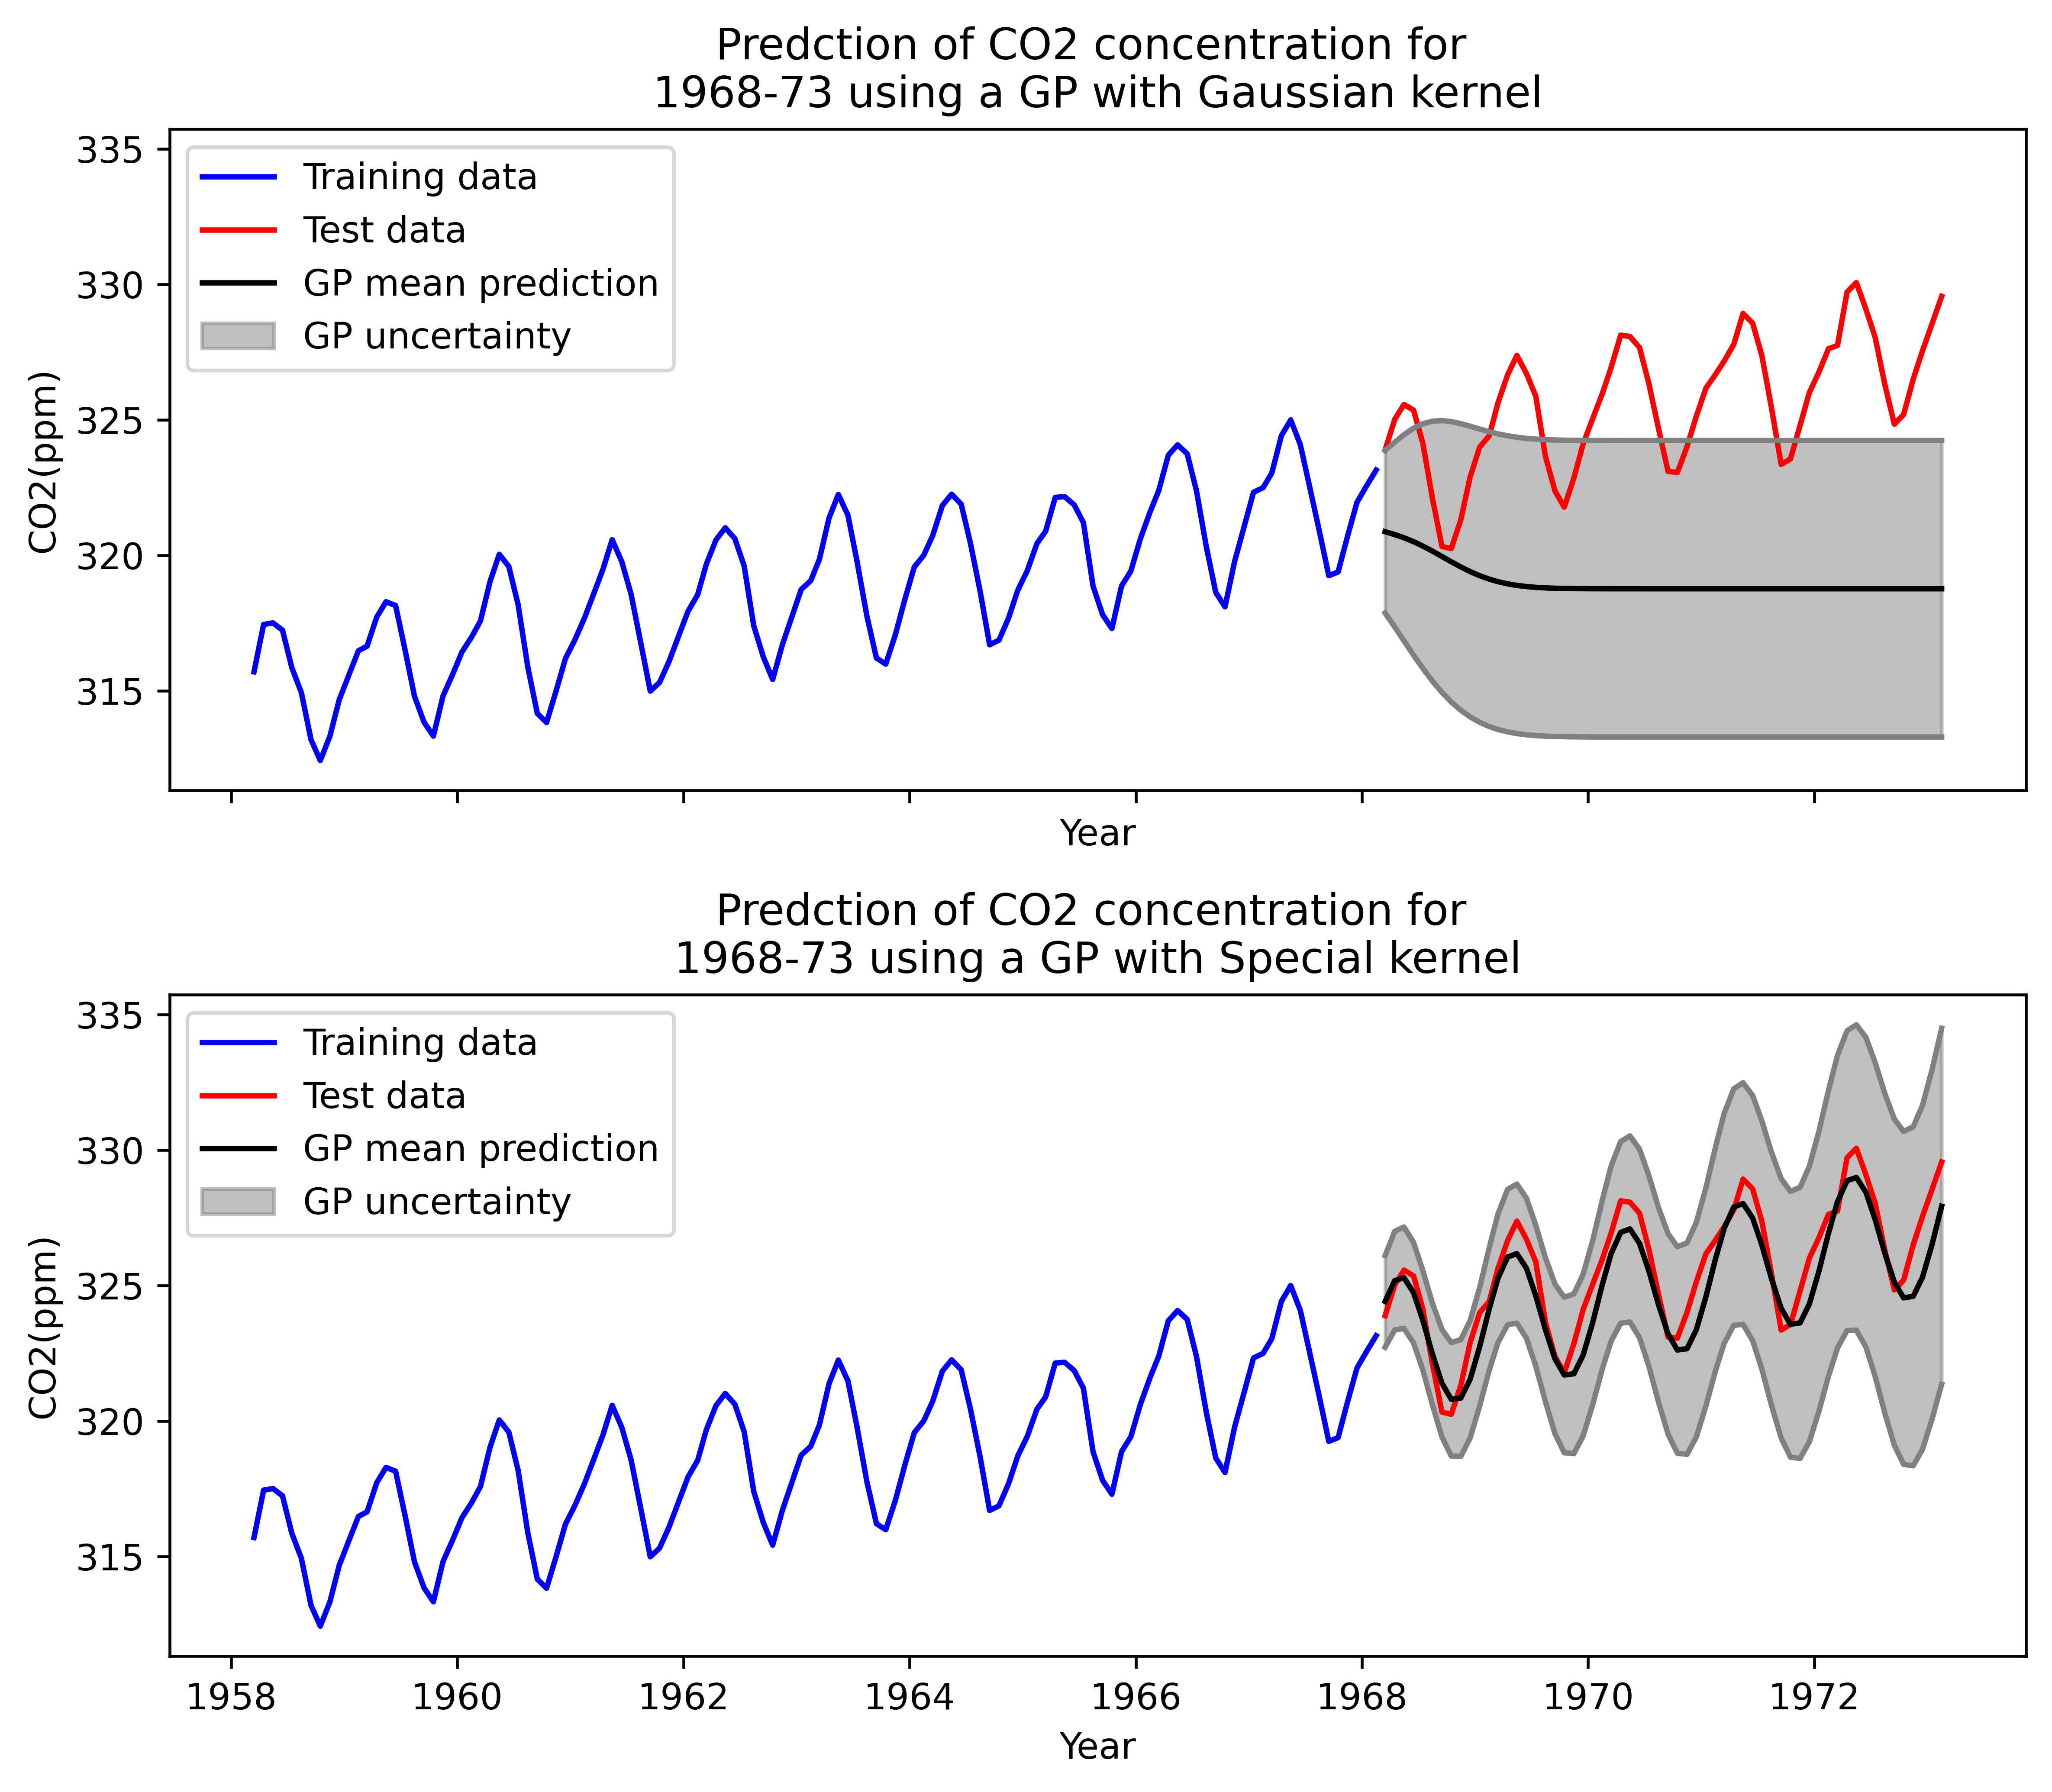

In [28]:
fig, axes = plt.subplots(
    ncols=1, nrows=2, sharex=True, sharey=True, dpi=600, figsize=(8, 7)
)

plot_co2_predictions(
    axes[0],
    "Predction of CO2 concentration for \n1968-73 using a GP with Gaussian kernel",
    X,
    y_raw,
    y_mean,
    y_std,
    X_predict,
    y_predict,
    prediction_mean_gaussian_kernel,
    var_gaussian_kernel,
)

plot_co2_predictions(
    axes[1],
    "Predction of CO2 concentration for \n1968-73 using a GP with Special kernel",
    X,
    y_raw,
    y_mean,
    y_std,
    X_predict,
    y_predict,
    prediction_mean_special_kernel,
    var_special_kernel,
)

plt.tight_layout()
plt.show()


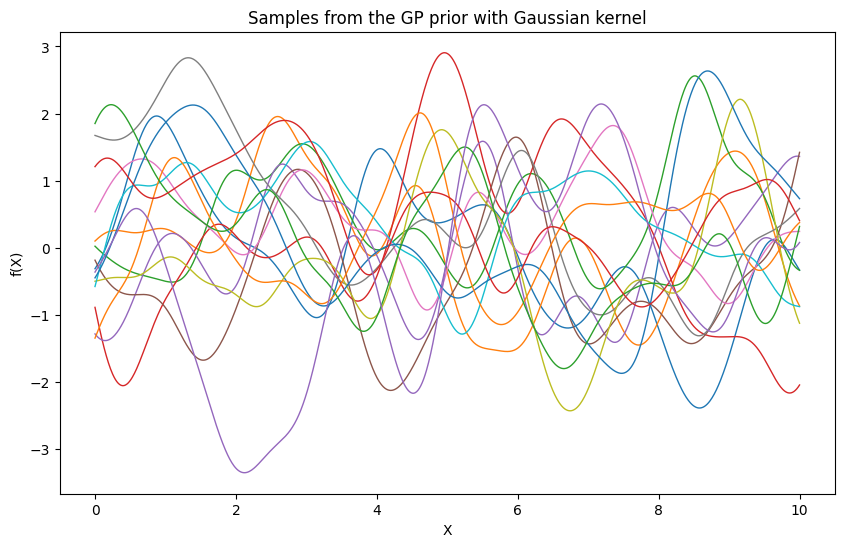

In [29]:
eta = np.array([2.0])  # Kernel hyperparameter gamma
n_samples = 1000  # Number of input points
n_functions = 15  # Number of functions to sample

# Create input points X
X = np.linspace(0, 10, n_samples).reshape(-1, 1)

# Compute the covariance matrix K
K = gaussian_kernel(X, X, eta)

# Draw samples from the multivariate normal distribution
samples = np.random.multivariate_normal(
    mean=np.zeros(n_samples), cov=K, size=n_functions
)

# Plot the samples
plt.figure(figsize=(10, 6))
for i in range(n_functions):
    plt.plot(X, samples[i], lw=1)
plt.title("Samples from the GP prior with Gaussian kernel")
plt.xlabel("X")
plt.ylabel("f(X)")
plt.show()

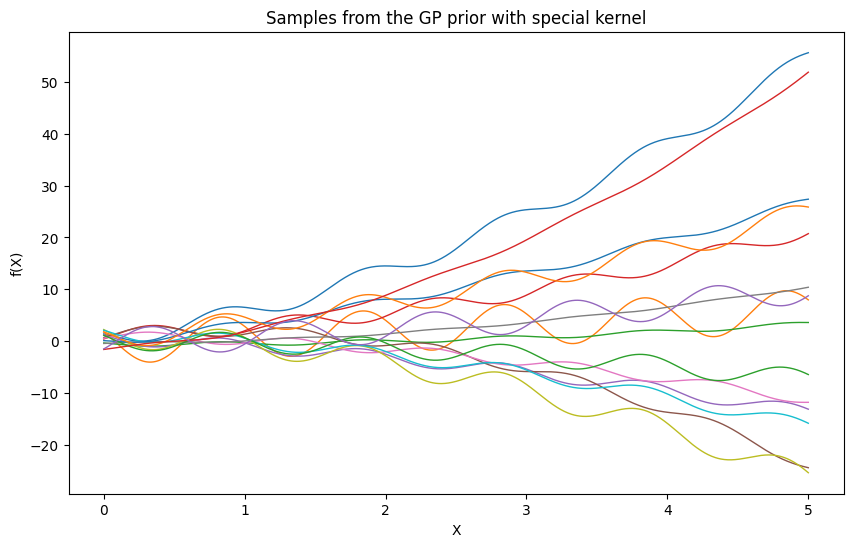

In [30]:
eta = np.array([2.2223, 8.8889])  # Kernel hyperparameter gamma
n_samples = 1000  # Number of input points
n_functions = 15  # Number of functions to sample

# Create input points X
X = np.linspace(0, 5, n_samples).reshape(-1, 1)

# Compute the covariance matrix K
K = special_kernel(X, X, eta)

# Draw samples from the multivariate normal distribution
samples = np.random.multivariate_normal(
    mean=np.zeros(n_samples), cov=K, size=n_functions
)

# Plot the samples
plt.figure(figsize=(10, 6))
for i in range(n_functions):
    plt.plot(X, samples[i], lw=1)
plt.title("Samples from the GP prior with special kernel")
plt.xlabel("X")
plt.ylabel("f(X)")
plt.show()